In [39]:
import numpy as np
from math import factorial
from cmath import exp
from numba import jit, cuda
import numba as nb


eps = 0


def simplex_content(j, n_dims, signed, *args):
    """
    Compute simplex content (j-dim-volume) using Cayley-Menger Determinant
    :param j: dimension of simplex
    :param n_dims: dimension of R^n space
    :param signed: bool denoting whether to calculate signed content or unsigned content
    :param args: v0, v1, ... vectors for the coordinates of the vertices defining the simplex

    :return: vol: volume of the simplex
    """
    assert(n_dims == len(args[0]))
    assert(isinstance(signed, bool))
    n_vert = len(args)
    assert(n_vert == j+1)

    if n_dims > j:
        assert(not signed)

    if not signed:
        # construct Cayley-Menger matrix
        B = np.zeros([j+2, j+2])
        B[:, 0] = 1
        B[0, :] = 1
        B[0, 0] = 0
        for r in range(1, j+2):
            for c in range(r+1, j+2):
                vr = args[r-1]
                vc = args[c-1]
                B[r, c] = np.linalg.norm(vr-vc) ** 2
                B[c, r] = B[r, c]
        vol2 = (-1)**(j+1) / (2**j) / (factorial(j)**2) * np.linalg.det(B)
        if vol2 < 0:
            print("Warning: zeroing small negative number {0}".format(vol2))
        vol = np.sqrt(max(0, vol2))
    else:
        # matrix determinant
        mat = np.zeros([j, j])
        for r in range(j):
            mat[:, r] = args[r] - args[-1]
        vol = np.linalg.det(mat) / factorial(j)

    return vol

In [40]:
BDIM2 = (16, 8)
GDIM2 = (32, 16)
BDIM3 = (8, 8, 4)
GDIM3 = (16, 16, 8)


def simplex_ft_bw_gpu(dF, V, E, D, res, t, j, mode='density', gpuid=0):
    """
    Fourier transform backwards method for signal defined on a j-simplex set in R^n space
    :param dF: sensitivities on frequency modes (res[0], res[1], ..., res[-1]/2+1, n_channel)
    :param V: vertex list. float ndarray of shape (n_vertex, n_dims)
    :param E: element list. int ndarray of shape (n_edge, j or j+1)
              if j cols, then assume sign of area using RHR and use ghost node.
    :param D: int ndarray of shape (n_vertex, n_channel)
    :param t: n_dims tuple of period in each dimension
    :param j: dimension of simplex set
    :param mode: normalization mode.
                 'density' for preserving density, 'mass' for preserving mass
    :param gpuid: gpu device id

    :return: dV: output tensor of shape (n_vertex, n_dims)
     """
    cuda.select_device(gpuid)
    n_dims = V.shape[1]
    assert(n_dims in [2])  # GPU implementation not yet implemented for other dimensions
    assert(j == 2) # not yet implemented for other simplices
    assert(n_dims == len(res))  # consistent spacial dimensionality
    assert(E.shape[0] == D.shape[0])  # consistent vertex numbers
    assert(mode in ['density', 'mass'])

    # number of columns in E
    ghost = E.shape[1] == j and n_dims == j
    assert (E.shape[1] == j+1 or ghost)
    if ghost:
        V = np.append(V, np.zeros([1, n_dims]), axis=0)
        E = np.append(E, V.shape[0] - 1 + np.zeros([E.shape[0], 1], dtype=np.int), axis=1)
    n_elem = E.shape[0]
    n_vert = V.shape[0]
    n_channel = D.shape[1]

    # normalize frequencies
    omega = np.array([2*np.pi/ti for ti in t])

    # initialize output dV
    dV_shape = list(V.shape)
    dFdV_shape = tuple([j+1, n_dims] + list(dF.shape))
    dV = np.zeros(dV_shape, dtype=np.complex128)
    dFdV = np.zeros(dFdV_shape, dtype=np.complex128)

    # compute content array and P array
    C = np.zeros(n_elem)
    P = np.zeros([n_elem, j+1, n_dims])

    for ie in range(n_elem):
        # content array
        verts = E[ie]
        vert_arrays = tuple([V[vert] for vert in verts])
        C[ie] = factorial(j) * simplex_content(j, n_dims, ghost, *vert_arrays)
        # p array
        P[ie] = V[E[ie]]

    # fftshift for dF
    dF = np.fft.fftshift(dF, axes=tuple(range(n_dims-1)))
        
    # move arrays to device
    V_mem = cuda.to_device(V)
    E_mem = cuda.to_device(E)
    D_mem = cuda.to_device(D)
    C_mem = cuda.to_device(C)
    P_mem = cuda.to_device(P)
    dF_mem = cuda.to_device(dF)
#     dV_mem = cuda.to_device(dV)
    dFdV_mem = cuda.to_device(dFdV)
    omega_mem = cuda.to_device(omega)

    sum_reduce = cuda.reduce(lambda a, b: a + b)
    # invoke kernel function
    if n_dims == 2:
        for ie in range(n_elem):
            simplex_ft_bw_kernel2[GDIM2, BDIM2](ie, V_mem, E_mem, D_mem, C_mem, P_mem, omega_mem, dF_mem, dFdV_mem)
            for ip in range(j+1):
                for idim in range(n_dims):
                    tmp_sum = sum_reduce(dFdV_mem[ip, idim].ravel())
                    dV[E[ie, ip], idim] += tmp_sum
        
    elif n_dims == 3:
        print("TODO: Not implemented for 3D yet...")
#     dV_mem.to_host()

    if mode == 'density':
        if not np.array_equal(res, res[0]*np.ones(len(res))):
            print("WARNING: density preserving mode not correctly implemented if not all res are equal")
        dV *= res[0] ** j
    return dV

@cuda.jit
def simplex_ft_bw_kernel2(ie, V, E, D, C, P, omega, dF, dFdV):
    r = dF.shape[:-1]
    j = 2
    n_elem = E.shape[0]
    n_dims = V.shape[1]
    n_channel = D.shape[1]

    # position within a grid
    start_u, start_v = cuda.grid(2)

    # u, v strides
    stride_u = cuda.gridDim.x * cuda.blockDim.x
    stride_v = cuda.gridDim.y * cuda.blockDim.y

    uv = cuda.local.array(shape=(2), dtype=nb.float64)

    for iu in range(start_u, int(r[0]), stride_u):
        u = (iu - r[0] / 2) * omega[0]
        for iv in range(start_v, int(r[1]), stride_v):
            v = iv * omega[1]
            uv[0] = u
            uv[1] = v
            for ic in range(n_channel):
                fac = simplex_ft_bw_device2(P[ie], uv, dF[iu, iv, ic], C[ie])
                ct = 0
                for ip in range(j+1):
                    dFdV[ip, 0, iu, iv, ic] = fac[ct]
                    dFdV[ip, 1, iu, iv, ic] = fac[ct+1]
                    ct += 2


@cuda.jit(device=True)
def simplex_ft_bw_device2(p, uv, df, c):
    j = p.shape[0]-1
    n_dims = len(uv)
    sig0 = 0
    sig1 = 0
    sig2 = 0
    S = 0.5
    if not (uv[0] == 0 and uv[1] == 0):
        for d in range(n_dims):
            sig0 += p[0, d] * uv[d]
            sig1 += p[1, d] * uv[d]
            sig2 += p[2, d] * uv[d]
        s01 = 1/(sig0-sig1)
        s12 = 1/(sig1-sig2)
        s20 = 1/(sig2-sig0)
        e0 = -exp(-1j*sig0)*s01*s20
        e1 = -exp(-1j*sig1)*s12*s01
        e2 = -exp(-1j*sig2)*s20*s12
        fac0 = e0*(-1j-s01+s20)-e1*s01+e2*s20
        fac1 = e1*(-1j-s12+s01)-e2*s12+e0*s01
        fac2 = e2*(-1j-s20+s12)-e0*s20+e1*s12
        S = e0+e1+e2
    
    fac = (fac0, fac1, fac2)
    # sorry for the ugly code below. numba doesn't allow lists and it's a real pain.
    ip = 0
    pnx  = p[(ip+1)%(j+1), 0]
    pny  = p[(ip+1)%(j+1), 1]
    pnnx = p[(ip+2)%(j+1), 0]
    pnny = p[(ip+2)%(j+1), 1]
    res00 = df*(uv[0]*fac[ip]*c-S*(pny-pnny))
    res01 = df*(uv[1]*fac[ip]*c-S*(-pnx+pnnx))
    ip = 1
    pnx  = p[(ip+1)%(j+1), 0]
    pny  = p[(ip+1)%(j+1), 1]
    pnnx = p[(ip+2)%(j+1), 0]
    pnny = p[(ip+2)%(j+1), 1]
    res10 = df*(uv[0]*fac[ip]*c-S*(pny-pnny))
    res11 = df*(uv[1]*fac[ip]*c-S*(-pnx+pnnx))
    ip = 2
    pnx  = p[(ip+1)%(j+1), 0]
    pny  = p[(ip+1)%(j+1), 1]
    pnnx = p[(ip+2)%(j+1), 0]
    pnny = p[(ip+2)%(j+1), 1]
    res20 = df*(uv[0]*fac[ip]*c-S*(pny-pnny))
    res21 = df*(uv[1]*fac[ip]*c-S*(-pnx+pnnx))
    return res00, res01, res10, res11, res20, res21

In [41]:
# from transform import simplex_ft_bw_gpu
import numpy as np
from time import time

V = np.array([[0.2,0.2],
              [0.8,0.5],
              [0.8,0.8],
              [0.6,0.8]])
V = V+1e-10*np.random.rand(*V.shape)
E = np.array([[0,1],
              [1,2],
              [2,3],
              [3,0]])
# E = np.array([[0,1,2],
#               [2,3,0]])
D = np.ones((E.shape[0], 1))

# Freq = simplex_ft_gpu(V, E, D, (256,256),(1,1),2)
dF = np.ones((256, 128, 1), dtype=np.complex_)
dV = simplex_ft_bw_gpu(dF, V, E, D, (256, 256), (1,1), 2, mode='mass')

In [42]:
print(dV)

[[ 1.11572231e+03+4.59734181e+03j -4.23790969e+03-1.01843844e+04j]
 [ 2.05738148e+04-8.26306080e+03j -2.97057511e+04+1.65260633e+04j]
 [ 1.08120883e+03-2.24760287e-01j -1.43322339e+03-9.84060344e+00j]
 [-3.47682914e+02+7.41307263e+02j  1.49112429e+02-4.78704241e+02j]
 [ 1.18033669e+06-6.70171178e-01j -1.88633647e+06+5.03016246e-01j]]


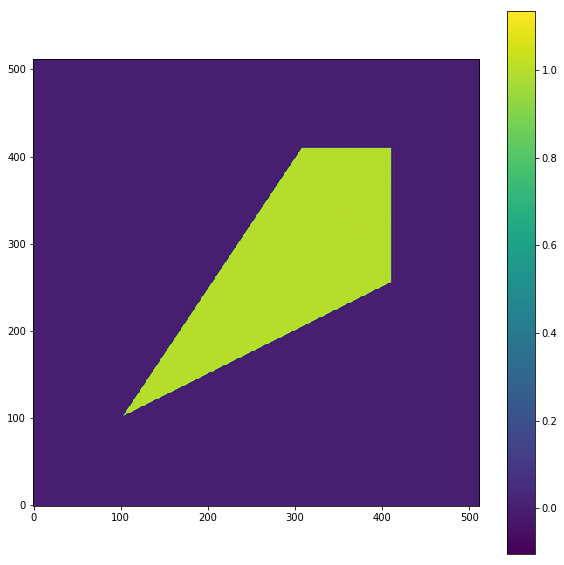

In [8]:
from transform import simplex_ft_cpu
Freq = simplex_ft_cpu(V, E, D, (512,512),(1,1),2)
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(np.fft.irfft2(np.squeeze(Freq), (512,512)), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
dV = simplex_ft_bw_gpu(dF, V, E, D, (256, 256), (1,1), 2, mode='mass')
print(dV)

In [27]:
dF = np.ones((512, 256, 1), dtype=np.complex_)

from transform import simplex_ft_cpu, simplex_ft_gpu
dV_list = []
delta_list = [10**(-i) for i in range(1,8)]
for delta in delta_list:
#     dV_fd = np.zeros(list(V.shape)+list(dF.shape), dtype=np.complex_)
    dV_fd = np.zeros(list(V.shape), dtype=np.complex_)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V_p = V.copy()
            V_m = V.copy()
            V_p[i, j] += delta
            V_m[i, j] -= delta
            Freq_p = simplex_ft_gpu(V_p, E, D, (512,512),(1,1),2)
            Freq_m = simplex_ft_gpu(V_m, E, D, (512,512),(1,1),2)
            dV_fd[i,j] = np.sum(Freq_p[:256,:128] - Freq_m[:256,:128]) / delta / 2
    dV_list.append(dV_fd)

In [36]:
print(dV_list[-1])

[[ -5130.00496105 +8649.60269184j  -3089.32334995 +9655.55860602j]
 [  8896.25870373+34071.2147038j  -19433.50908205  -737.99379944j]
 [-13830.78963178+38121.20483936j  12827.52542963+12257.52274114j]
 [-17213.9317403  -5446.29025501j  24413.51745494+11469.14214016j]]


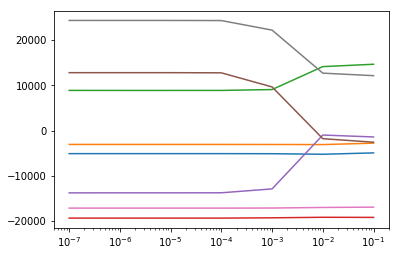

In [29]:
plt.figure()
for ii in range(V.shape[0]):
    for jj in range(V.shape[1]):
        q0 = [dV_list[i][ii,jj] for i in range(len(dV_list))]
        plt.semilogx(delta_list, np.real(q0))
plt.show()

TypeError: Invalid dimensions for image data

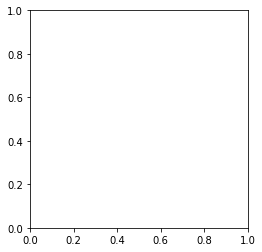

In [28]:
plt.figure()
plt.imshow(np.squeeze(np.absolute(dV_list[6][3,1]-dV_list[5][3,1])).astype(np.float64), origin='lower', vmin=0, vmax=0.01)
plt.colorbar()
plt.show()

In [ ]:
from transform import simplex_ft_gpu
delta = 0.1
Freq = simplex_ft_gpu(V, E, D, (256,256),(1,1),2)
dV_fd = np.zeros_like(V, dtype=np.complex_)
for i in range(V.shape[0]):
    for j in range(V.shape[1]):
        V_delta = V.copy()
        V_delta[i, j] += delta
        Freq_delta = simplex_ft_gpu(V_delta, E, D, (256,256),(1,1),2)
        dV_fd[i,j] = np.sum((Freq_delta - Freq)) / delta
# print(dV_fd)
print(np.sum(Freq))

In [ ]:
eps = 1e-5
k = np.array([0,0])+eps*np.random.randn(2)
x1 = np.array([0,0])
x2 = np.array([.5, .25])
x3 = np.array([.25, .5])
